In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL as pl

import denoise as dn

## explicações

Toda imagem funciona como uma matriz.
<br>
As em cinza são as matrizes mais simples. Elas são apenas dois vetores com x pixels por y pixels.
<br>
Ex:

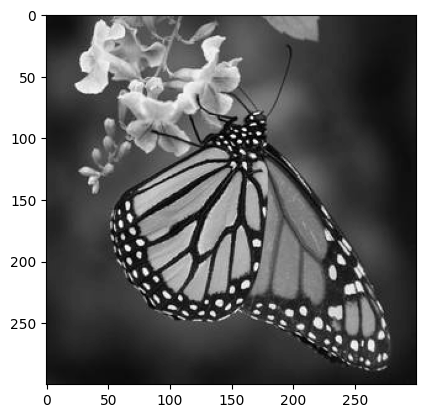

In [8]:
img = cv2.imread('test3.jpg')
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #cinzando a imagem que antes era RGB

plt.imshow(img_,cmap='gray')

In [9]:
print(img_) #mostrando sua matriz

[[17 17 16 ... 22 22 22]
 [17 17 16 ... 22 22 22]
 [17 17 16 ... 22 22 22]
 ...
 [33 31 30 ... 16 16 16]
 [34 33 31 ... 16 16 16]
 [36 35 33 ... 16 16 16]]


In [10]:
img_.shape # veja, são dois vetores com cada um com o seu número de pixels

(300, 300)

para que ele possa ser averiguado em um filtro de mediana com matrix 3x3, todos esses Y * X pixels existentes
devem ser organizados em uma matriz com (Y * X)/(3 * 3) vetores de pixels, com cada um contendo 3x3 pixels organizados em uma matriz 3x3. <br>
Ex:

In [15]:
x,y = img_.shape

d = 3 # n da dimensão de matriz que queremos

nova_img = img_.reshape(((x*y)//(d*d)),d,d)

nova_img

array([[[17, 17, 16],
        [16, 15, 15],
        [14, 14, 14]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 17, 17]],

       [[18, 20, 21],
        [23, 24, 24],
        [25, 28, 30]],

       ...,

       [[18, 18, 18],
        [18, 17, 16],
        [15, 17, 17]],

       [[17, 17, 17],
        [17, 17, 17],
        [18, 16, 15]],

       [[16, 18, 18],
        [17, 15, 16],
        [16, 16, 16]]], dtype=uint8)

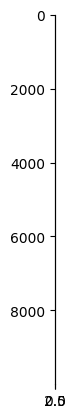

In [16]:
plt.imshow(nova_img) # veja que neste formato ela não pode ser interpretada

In [17]:
# vimos acima, que no seu novo tamanho, ela já uma matriz com N pixels 3x3,
# pronta para ser filtrada, mas vamos ter ctz disso nisso aqui

nova_img.shape

(10000, 3, 3)

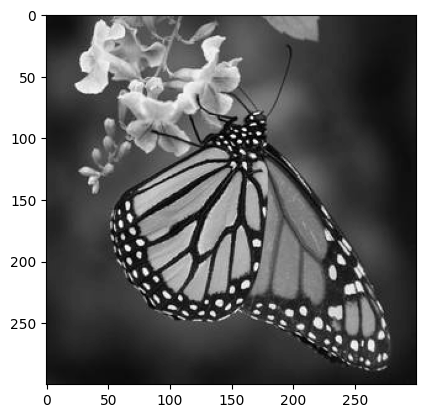

In [18]:
#podemos trazer-la de volta ao formato original assim

shape_or = img_.shape # tamanho da imagem original (cinza)

res_img = nova_img.reshape(shape_or)


plt.imshow(res_img,cmap='gray')

In [19]:
#seria inviável trabalhar com a original, pois ela sim possui um escalonamento de matriz diferente por ser RGB
img.shape # imagem original

(300, 300, 3)

In [20]:
img

array([[[17, 17, 17],
        [17, 17, 17],
        [16, 16, 16],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[17, 17, 17],
        [17, 17, 17],
        [16, 16, 16],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[17, 17, 17],
        [17, 17, 17],
        [16, 16, 16],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       ...,

       [[33, 33, 33],
        [31, 31, 31],
        [30, 30, 30],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[34, 34, 34],
        [33, 33, 33],
        [31, 31, 31],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[36, 36, 36],
        [35, 35, 35],
        [33, 33, 33],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]]], dtype=uint8)

só em projetos avançados para brincar-mos isso acima
<br>

<hr>

 vamos criar uma função para adicionar ruído a imagem original (cinza)

In [21]:




#criando função para o ruido impulsivo (sal e pimenta)
def adicionar_ruido(img_or_, modo='s&p',grau=.4):
    img_n =np.zeros(img_or_.shape) #criando uma nova img a partir da original
    linhas , colunas = img_n.shape #pegando o numero de linhas e colunas da imagem
    n_pixels = linhas*colunas
    if 's' in modo:
      pixels = np.random.randint(300, int(10000)) # número de pixels com sal
      for i in range(pixels):
          y_coord=np.random.randint(0, linhas - 1) #escolhendo de maneira aleatoria onde o ruido de sal vai cair nas linhas da imagem
          x_coord=np.random.randint(0, colunas - 1) #escolhendo de maneira aleatoria onde o ruido de sal vai cair nas colunas da imagem
          img_n[y_coord][x_coord] = np.random.randint(90,255) #adicinando o sal, com pixelagem de 90 a 255, sendo escolhido no aleatório
          
    if 'p' in modo:
      pixels = np.random.randint(300,int(10000)) # número de pixels com pimenta
      for i in range(pixels):
          y_coord=np.random.randint(0, linhas - 1) #escolhendo de maneira aleatoria onde o ruido de pimenta vai cair nas linhas da imagem
          x_coord=np.random.randint(0, colunas - 1) ##escolhendo de maneira aleatoria onde o ruido de pimenta vai cair nas colunas da imagem
          img_n[y_coord][x_coord] = np.random.randint(0,10) #adicinando a pimenta, com pixelagem de 0 a 10, sendo escolhido no aleatório
           
    return cv2.add(img_or_,img_n.astype(np.uint8)) #retornando a matrix da imagem já ruidosa como uint8 para não dá erro na sua acoplagem ou subtração com a original


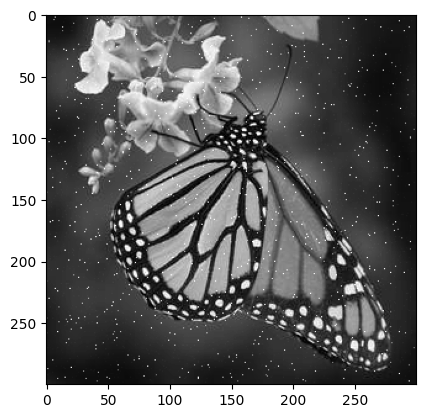

In [22]:
img_ruido = adicionar_ruido(img_)

plt.imshow(img_ruido,cmap='gray')

como o trabalho envolve o uso de mediana, eu achei legal fazer a mediana a mão msm

In [25]:
def mediana2D(arr):
    lista_n = [] #criando uma nova lista para que nela seja ordenada o pixel 3x3 e assim seja pega a sua mediana
    for l in arr:
        for p in l:
            lista_n.append(p)
    lista_n.sort()
    
    #agora ordenado em uma lista de 1D, vamos pegar a danadinha da mediana
    
    #simples, nem deveria comentar aqui
    # caso o numero de termos for par, ele vai pegar os dois termos que estão no meio 
    #e tirar a sua média, e assim encontrar a mediana, fim! 
    if not len(lista_n)%2:
        casa_n1 = len(lista_n)//2
        casa_n2 = casa_n1 + 1
        mediana = (lista_n[casa_n2]+lista_n[casa_n1])/2
        return mediana
    
    #se for impar, ele simplesmente vai pegar o danadinho que tiver no meio, fim!
    else:
        casa_n1 = len(lista_n)//2
        casa_n = casa_n1 
        mediana = lista_n[casa_n]
        return mediana


In [33]:
#vamos criar um pixel 3x3 para testar isso

pixel_test = [[23,55,76],
              [20,26,24],
              [26,21,22]]

mediana_m = mediana2D(pixel_test) # nossa mediana
mediana_r = np.median(pixel_test) # mediana real

print(f'nossa mediana -> [{mediana_m}] | mediana real -> [{mediana_r}]')

nossa mediana -> [24] | mediana real -> [24.0]


In [34]:
pixel_test

[[23, 55, 76], [20, 26, 24], [26, 21, 22]]

In [40]:
def mediana2D_filtro(arr,modo='med',T=10):
    nova_arr = arr #criando um novo pixel apartir do original
#    desv = desv_pixel(arr)
    mediana_ = mediana2D(arr) #pegando a mediana do pixel 
    c = 0 #criando a interação da coluna que ele vai percorrer 
    l = 0 #criando a interação da linha que ele vai andar

    for lin in arr: #andando as linhas das colunas 
        for p in lin: #andando no número das linhas 
           # print(f'o q eh:{p} | oq tô pegando {arr[c][l]}')
           
            #lembrando, que o T é o filtro mestre deste filtro mediano
            #usar a condição de p>mediana para mudar, não vai tirar a pimenta do pixel 3x3, pois ela é muito pequena
            # mas com tudo, deixei ao critério em qual vcs vão querer usar

            # modo = "max" vai pegar os p que forem maior que a mediana ser igual a mediana
            # modo = "T" vai pegar os p que tiver a uma distância maior T da mediana, e igualar a ela

            if modo=='T':
              #print(f"vc escolheu o T={T}")
              if abs(p-mediana_)>T:
                  p = mediana_ # se a diferença do pixel para a mediana, for maior do que é aceita pelo parâmetro T, este pixel é trocado pela mediana 
                  nova_arr[c][l] = p #e ele é adicionado de volta ao conjunto de pixels 3x3
              else:
                  nova_arr[c][l] = p # eu N vi nada 

            elif modo=='med':
              #print('vc escolheu maxMed')
              if p>mediana_:
                  p = mediana_ # se o pixel em questão for maior do que a mediana, o danadinho será imediatamente substituído pela mediana 
                  nova_arr[c][l] = p #e ele é adicionado de volta ao conjunto de pixels 3x3
              else:
                  nova_arr[c][l] = p # eu N vi nada 

            l = l+1 # fazer o código andar nas linhas 
        c = c+1 # fazer o código percorrer as colunas 
        l = 0 #toda vez que o código terminar uma linha, em uma coluna, ele deve recomeçar sempre do zero, pq se não vai tentar andar em casas que não existem
    return np.array(nova_arr)


In [42]:
#testando isso no pixel real

pixel_test = [[23,55,76],
              [20,26,24],
              [26,21,22]]

px = np.array(pixel_test)
print(f'pixel anterior: \n {px}\n')

pixel_filtrado = mediana2D_filtro(px)


print(f'pixel filtrado: \n {np.array(pixel_filtrado)}')

pixel anterior: 
 [[23 55 76]
 [20 26 24]
 [26 21 22]]

pixel filtrado: 
 [[23 24 24]
 [20 24 24]
 [24 21 22]]


com isso, vamos fazer com que este filtro percorra todas as matrizes 3x3 da imagem, por assim filtrando todos os pixels dela.

In [43]:
#função para retirar o ruído (pela mediana de cada pixel de matriz)
def retirar_ruido(img_ori,modo="med",T=5,prt=True):
    rest_pixel = img_ori[0:(img_ori.shape[0]-(img_ori.shape[0]%9))] # tirando o excesso da imagem que não poderar ser organizada em pixels 3x3
    img_3D_ = img_ori.reshape((img_ori.shape[0]*img_ori.shape[1])//9,3,3) # reorganizando a imagem cinza, em pixels 3x3
    nova_img = np.zeros(img_3D_.shape) #np.zeros(img_3D.shape)
    i = 0 # interação para contagem de índices 
    c = 0 # interação para percorrer as colunas
    l = 0 # interação para andar as linhas 
    
    #visitando os pixels 3x3 e filtrando eles com a mediana
    size = len(img_3D_) # pegando o número de pixels 3x3
    for pixel in img_3D_:
      
        #print simples para mostrar a nossa taxa de produção
        if prt==True:
          print(f'indice: {i}/{size} ({(i*100/size):.2f}%)')
        #print(pixel)
        # criando novo pixel filtrado
        # um novo homem, que aceitou as boas novas da mediana, (sobre o regime do filtro T)
        novo_pixel = mediana2D_filtro(pixel,modo=modo,T=T)
        #print(novo_pixel)
        # devolvendo o colega para a casa dele
        nova_img[c] = novo_pixel
        
        c = c+1 # interação para fazer o código sair do lugar
        i+=1 # interação para fazer o índice de produção saber em qual percudo estamos 
        
    print('então...') # tentei fazer uma piadoca, mas não consegui ;-;
    nova_im = nova_img.reshape(*img_ori.shape) # reorganizando a imagem do jeito que a pegamos 
    # muito foda, né?
    
    print('foi... sheipado') # melhor do que academia :)
    return nova_im

Agora, vamos testar isso feito.

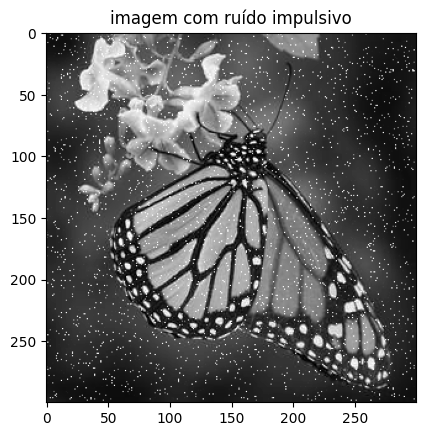

então...
foi... sheipado


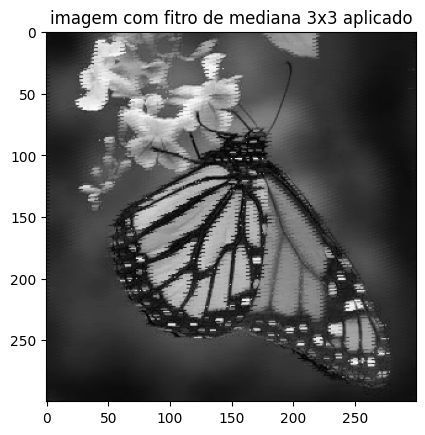

In [48]:
img_ruido = adicionar_ruido(img_)

plt.imshow(img_ruido,cmap='gray')
plt.title('imagem com ruído impulsivo')
plt.show()



img_filtrada = retirar_ruido(img_ruido,prt=False)

plt.imshow(img_filtrada,cmap='gray')
plt.title('imagem com fitro de mediana 3x3 aplicado')
plt.show()

### histogramas

para tal, vamos usar o pillow para se trabalhar com os histogramas, já que o que era para ser feito a mão, já fizemos. <br>
Vamos salvar as imagens para serem lidas pelo pillow e poderem ser trabalhadas nele.

In [50]:
cv2.imwrite('imgs/img_gray.png',img_) #salvando a imagem cinza na pasta 'imgs'

img_r = adicionar_ruido(img_)
cv2.imwrite('imgs/img_rui.png',img_r) # // // imagem com ruído

img_d = retirar_ruido(img_r,prt=False)
cv2.imwrite('imgs/img_den.png',img_d) # // // imagem com filtro aplicado

então...
foi... sheipado


True

Agora, vamos ler elas pelo pillow.

In [51]:
img_g = pl.Image.open('imgs/img_gray.png')
img_r = pl.Image.open('imgs/img_rui.png')
img_d = pl.Image.open('imgs/img_den.png')

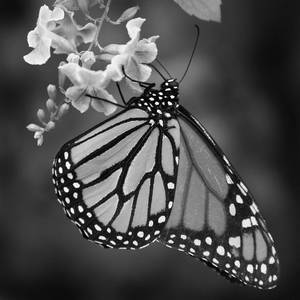

In [52]:
img_g

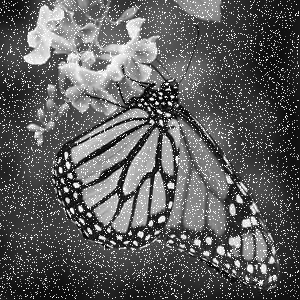

In [53]:
img_r

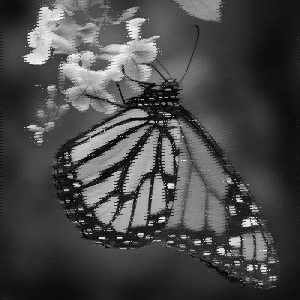

In [54]:
img_d

Com isso, vamos agora plotar os seus histogramas.

In [55]:
# tirando o histograma de cada uma

imgR = (img_r.histogram())
imgG = (img_g.histogram())
imgD = img_d.histogram()

/tmp/ipykernel_2934/1624903991.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


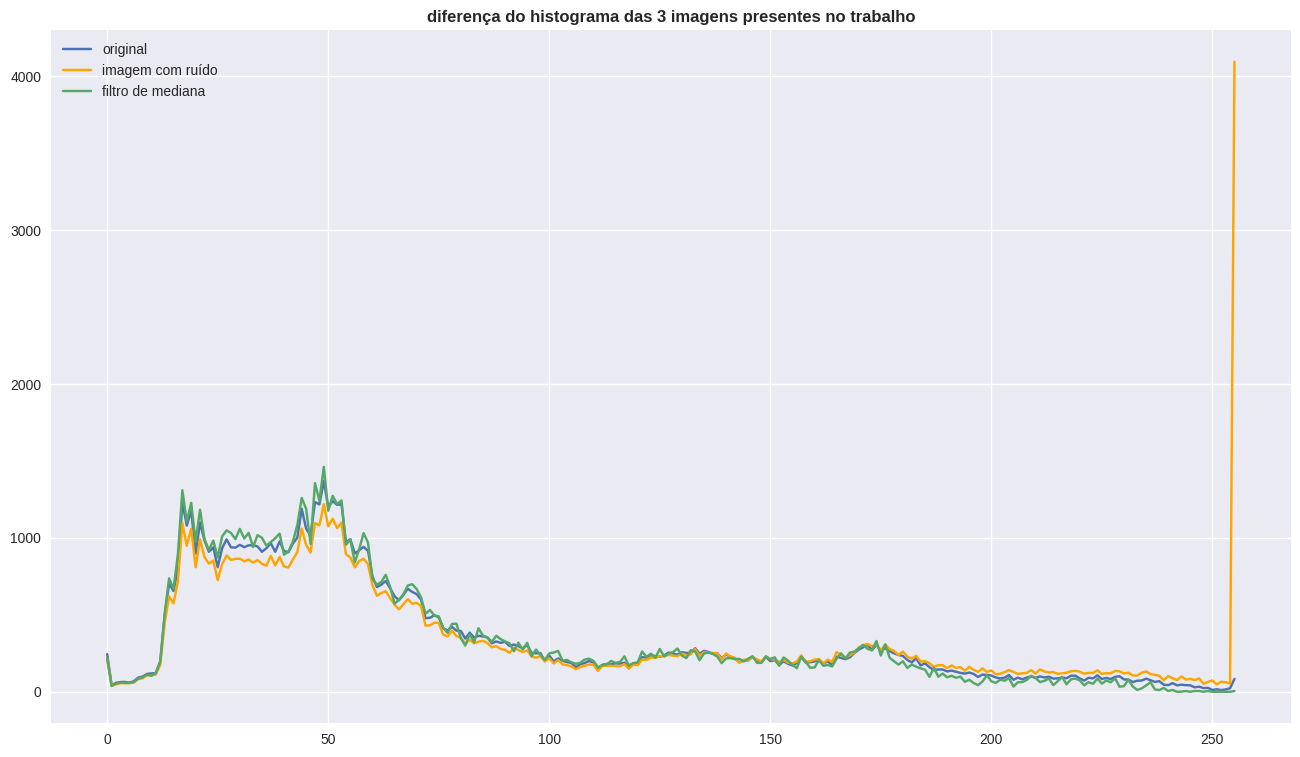

In [56]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(16,9))
plt.plot(imgG,label='original')
plt.plot(imgR,label='imagem com ruído',c='orange')
plt.plot(imgD,label='filtro de mediana')
plt.title('diferença do histograma das 3 imagens presentes no trabalho',fontweight='bold')
plt.legend()


Agora, o que na minha opinião é o gráfico mais elegante até aqui: o infográfico com 6 gráficos diferentes referentes ao que foi apresentado aí em cima.

Text(0.5, 1.0, 'hist. da imagem acima')

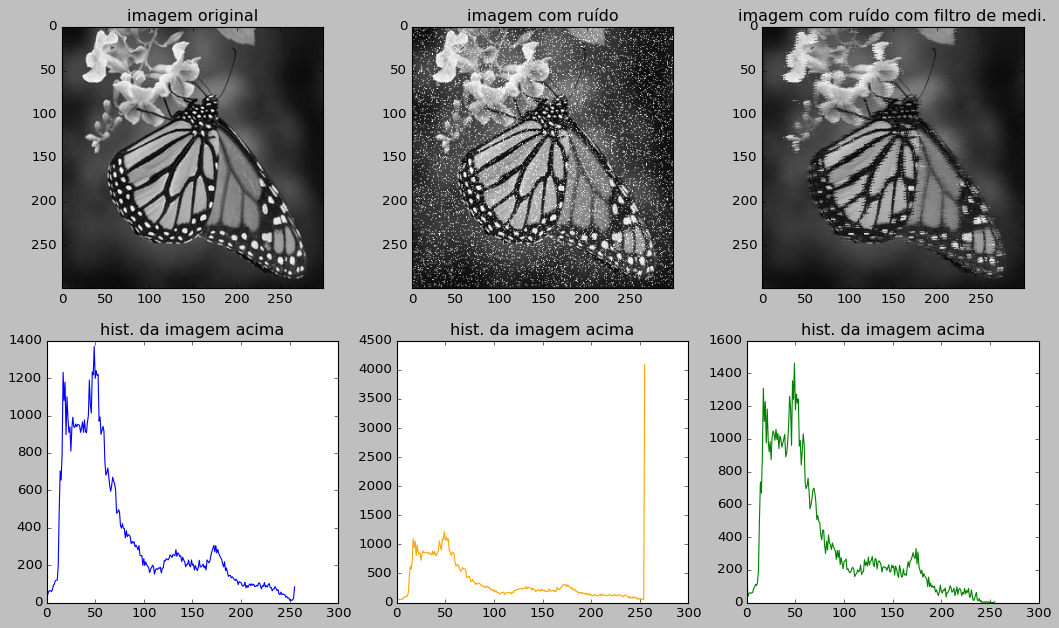

In [60]:
plt.style.use('classic')

fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(16,9))

axs[0][0].imshow(img_g,'gray')
axs[0][0].set_title('imagem original')

axs[0][1].imshow(img_r,'gray')
axs[0][1].set_title('imagem com ruído')

axs[0][2].imshow(img_d,'gray')
axs[0][2].set_title('imagem com ruído com filtro de medi.')

axs[1][0].plot(imgG,c='blue')
axs[1][0].set_title('hist. da imagem acima')


axs[1][1].plot(imgR,c='orange')
axs[1][1].set_title('hist. da imagem acima')

axs[1][2].plot(imgD,c='green')
axs[1][2].set_title('hist. da imagem acima')


#plt.savefig('histo_blocs.png',dpi=800)

<hr>

## Agradecimentos

É isso, obrigado por ter lido até aqui ;3